## Multinomial Logistics Regression
### Dry Beans Classification
### https://github.com/santiagoahl/dry-beans-classification

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn2pmml import sklearn2pmml
from sklearn2pmml import ColumnTransformer
from sklearn2pmml.pipeline import PMMLPipeline
from jpmml_evaluator import make_evaluator
from jpmml_evaluator.py4j import Py4JBackend
import warnings

In [163]:
warnings.filterwarnings('ignore')

In [164]:
# Data Import
df = pd.read_csv('../../../data/dry_bean.csv')
df.head(5)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [165]:
print(f'The bean classes are {df["Class"].unique()}')

The bean classes are ['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON']


## Data preprocessing

In [166]:
# Duplicates dropping
df.drop_duplicates(inplace=True)

## Balancing the dataset: SMOTE

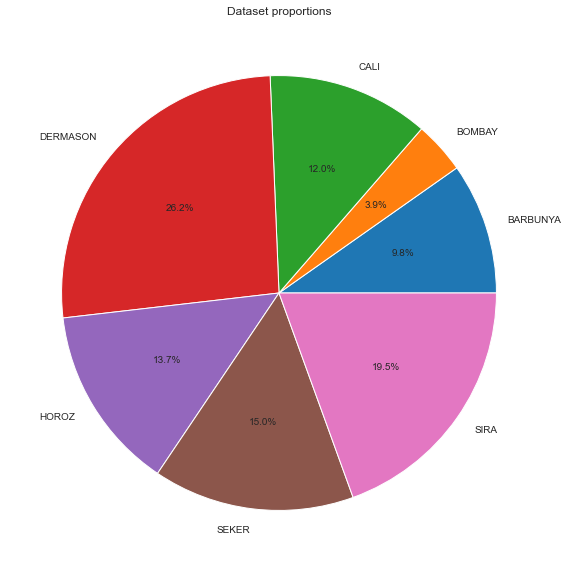

In [168]:
# Notice how unbalanced is the dataset
labels, counts = np.unique(df.Class, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

In [169]:
sm = SMOTE()

In [170]:
x = df.drop('Class', axis=1)
y = df.Class

In [171]:
x_sm, y_sm = sm.fit_resample(x, y)

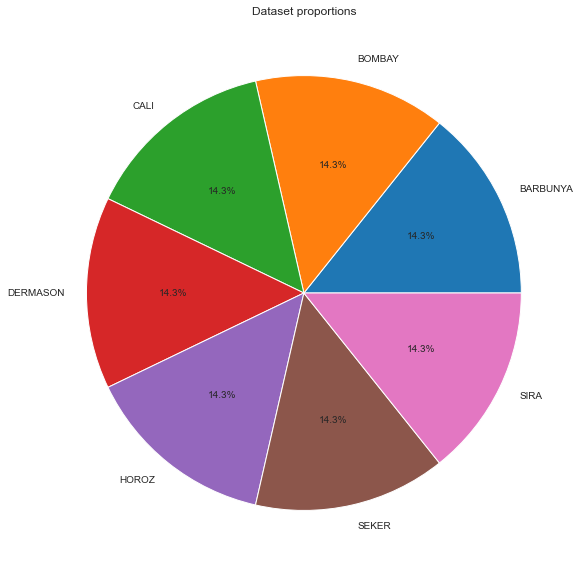

In [172]:
labels, counts = np.unique(y_sm, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

## Drop correlated features

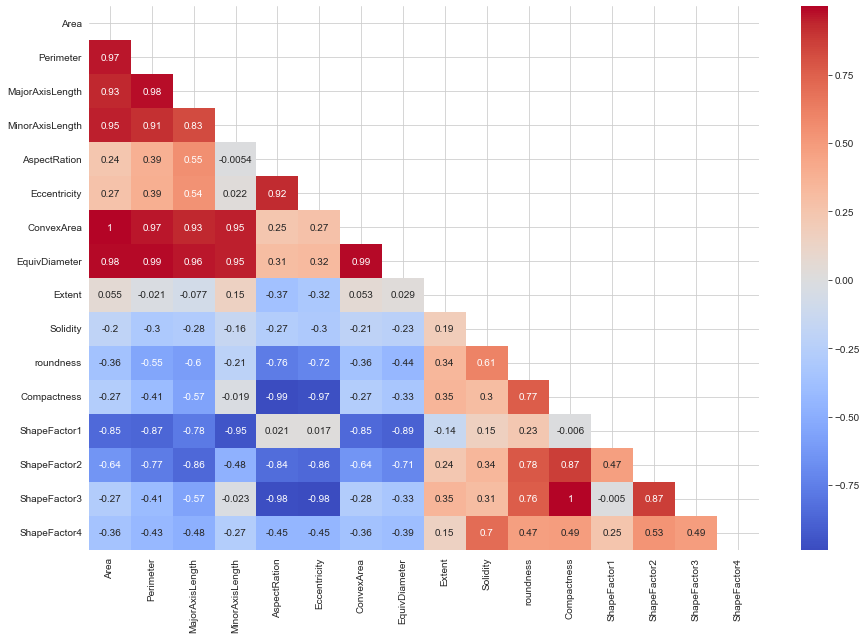

In [173]:
plt.figure(figsize=(15, 10))
sns.heatmap(data=df.corr(), cmap='coolwarm', mask=np.triu(df.corr()), annot=True)
plt.show()

We observe that ConvexArea is deeply correlated with Area, Perimeter, MajorAxisLength and MinorAxisLength.
EquivDiameter is also over correlated with several features. So we will drop both features.

In [174]:
x_sm.drop(['ConvexArea', 'EquivDiameter'], axis=1, inplace=True)

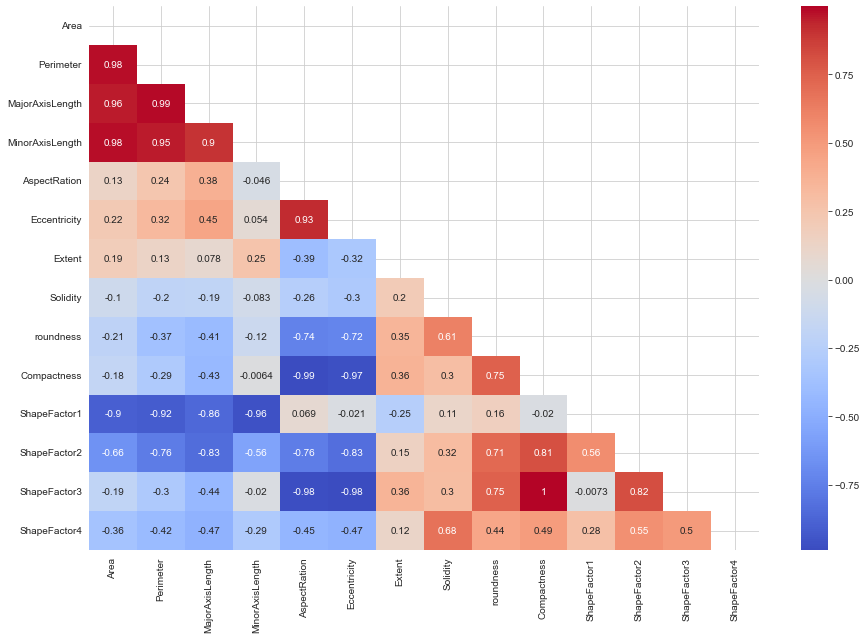

In [175]:
plt.figure(figsize=(15, 10))
sns.heatmap(data=x_sm.corr(), cmap='coolwarm', mask=np.triu(x_sm.corr()), annot=True)
plt.show()

## Data Preprocessing

In [176]:
# Selecting categorical and numeric features
sel_numeric = make_column_selector(dtype_include=np.number)
x_numerical = sel_numeric(x_sm)
sel_categorical = make_column_selector(dtype_exclude=np.number)
x_categorical = sel_categorical(x_sm)

In [177]:
# Create preprocessing pipelines for each datatype
trans_numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

In [178]:
trans_categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())]
)

In [179]:
# Putting the preprocessing steps together
transformer = ColumnTransformer([
    # ('categorical', trans_categorical, x_categorical) # if we have categorical features
    ('numerical', trans_numerical, x_numerical)],
    remainder='passthrough'
)

## Model Training

In [180]:
# Data Split
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, shuffle=True, test_size=0.2)

# Create pipeline with LogisticsRegression as classifier
pipeline = PMMLPipeline(steps=[
    ('transformer', transformer),
    ('classifier', LogisticRegression(max_iter = 1000))
])

pipeline.fit(x_train, y_train)
pipeline.verify(x_train.sample(n = 10))

In [181]:
y_pred = pipeline.predict(x_test)
y_pred

array(['SIRA', 'BARBUNYA', 'SEKER', ..., 'BOMBAY', 'BARBUNYA', 'SIRA'],
      dtype=object)

## Model Testing

In [182]:
print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')

The model accuracy is: 94.39999999999999%


In [183]:
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model f1 score is: 94.39999999999999%


<Figure size 1440x1440 with 0 Axes>

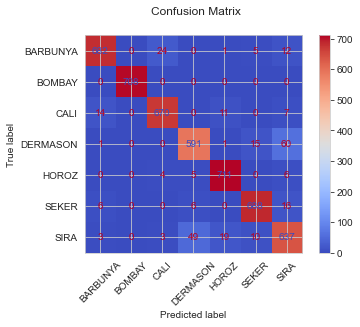

In [184]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='coolwarm')
plt.xticks(rotation=45)
plt.suptitle('Confusion Matrix')
plt.show()

## Export the model in PMML format

In [185]:
sklearn2pmml(pipeline, "../../../data/LogisticsRegressionDryBeansClassification.pmml")

## Model Scoring

In [186]:
# Load PMML model
backend  = Py4JBackend()
evaluator = make_evaluator(backend=backend, path="../../../data/LogisticsRegressionDryBeansClassification.pmml")

In [187]:
# Perform automated QA
evaluator.verify()

In [188]:
dfresult = evaluator.evaluateAll(x_test)

In [189]:
dfresult

,Class,probability(BARBUNYA),probability(BOMBAY),probability(CALI),probability(DERMASON),probability(HOROZ),probability(SEKER),probability(SIRA)
0,SIRA,3.636138e-03,3.160824e-08,6.153080e-04,5.786800e-02,2.784580e-04,2.561123e-02,9.119908e-01
1,BARBUNYA,9.974978e-01,8.778118e-05,2.413397e-03,1.146345e-14,4.178688e-08,7.341219e-07,2.190066e-07
2,SEKER,3.003711e-06,1.102378e-10,3.508471e-09,5.180482e-04,2.738316e-10,9.993779e-01,1.010180e-04
3,HOROZ,1.100215e-05,1.244458e-09,1.006669e-02,1.252085e-08,9.891965e-01,6.059373e-11,7.257859e-04
4,DERMASON,1.012335e-08,3.504922e-14,1.791378e-09,9.945792e-01,7.201898e-07,4.785957e-04,4.941474e-03
...,...,...,...,...,...,...,...,...
4960,BOMBAY,5.865749e-07,9.999411e-01,5.827481e-05,4.653277e-34,9.319420e-18,1.578172e-16,4.331658e-22
4961,SIRA,1.659544e-03,2.414348e-07,2.069850e-02,6.355718e-03,1.517816e-03,5.578804e-04,9.692103e-01
4962,BOMBAY,1.976668e-07,9.996171e-01,3.827037e-04,1.305026e-34,8.071655e-16,3.333701e-19,5.228631e-22
4963,BARBUNYA,9.907393e-01,2.976458e-05,9.210074e-03,7.796619e-12,1.804421e-06,4.452098e-06,1.458992e-05


## Model REST Scoring

In [195]:
from openscoring import Openscoring

# Creating an Openscoring object
# Openscoring server have to be running on base-url
os = Openscoring(base_url = "http://talend-02.dev.dmmil.net:8080", token="secret")

In [196]:
# Deploying a PMML model:
os.deployFile("LogisticsRegressionDryBeansClassification", "../../../data/LogisticsRegressionDryBeansClassification.pmml")

In [197]:
# Evaluating the model with data records from DataFrame
dfResponse = os.evaluateCsv("LogisticsRegressionDryBeansClassification", x_test)
dfResponse.head(5)

,Class,probability(BARBUNYA),probability(BOMBAY),probability(CALI),probability(DERMASON),probability(HOROZ),probability(SEKER),probability(SIRA)
0,SIRA,3.636138e-03,3.160824e-08,6.153080e-04,5.786800e-02,2.784580e-04,2.561123e-02,9.119908e-01
1,BARBUNYA,9.974978e-01,8.778118e-05,2.413397e-03,1.146345e-14,4.178688e-08,7.341219e-07,2.190066e-07
2,SEKER,3.003711e-06,1.102378e-10,3.508471e-09,5.180482e-04,2.738316e-10,9.993779e-01,1.010180e-04
3,HOROZ,1.100215e-05,1.244458e-09,1.006669e-02,1.252085e-08,9.891965e-01,6.059373e-11,7.257859e-04
4,DERMASON,1.012335e-08,3.504922e-14,1.791378e-09,9.945792e-01,7.201898e-07,4.785957e-04,4.941474e-03
